In [1]:
import os

In [2]:
# mainDir = pathlib.Path().resolve()
# original_datasets_dir = os.path.join(mainDir,"data")
# original_datasets_dir = os.path.join(original_datasets_dir,"train1")

#data_dir = 'jena_climate'

fname = 'jena_climate_2009_2016.csv'#os.path.join('', 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i,line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

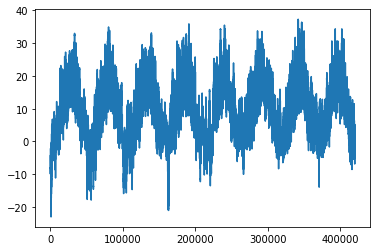

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:,1]
plt.plot(range(len(temp)),temp)

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -=mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size = batch_size)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step=step,
                      batch_size = batch_size)

test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step=step,
                      batch_size = batch_size)

In [8]:
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [9]:
#обычная неглубокая нейронка

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [10]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

C:\Users\KOSMON~1\AppData\Local\Temp/ipykernel_2632/4222724460.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
500/500 [==============================] - 10s 17ms/step - loss: 1.0397 - val_loss: 0.5602
Epoch 2/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3738 - val_loss: 0.3699
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2894 - val_loss: 0.3058
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2686 - val_loss: 0.3013
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2538 - val_loss: 0.3401
Epoch 6/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2442 - val_loss: 0.3130
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2373 - val_loss: 0.3155
Epoch 8/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2309 - val_loss: 0.3180
Epoch 9/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2270 - val_loss: 0.3185
Epoch 10/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2229 - val_l

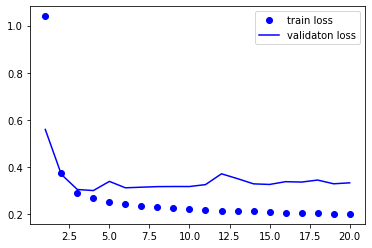

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs= range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='train loss')
plt.plot(epochs, val_loss, 'b', label='validaton loss')
plt.legend()
plt.show()